In [1]:
# prompt: connect drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


Predictions saved for AAPL in Dataset-A: drive/MyDrive/Modeling and Simulation/MonteCarlo/predictions/Dataset-A/AAPL_predictions.csv


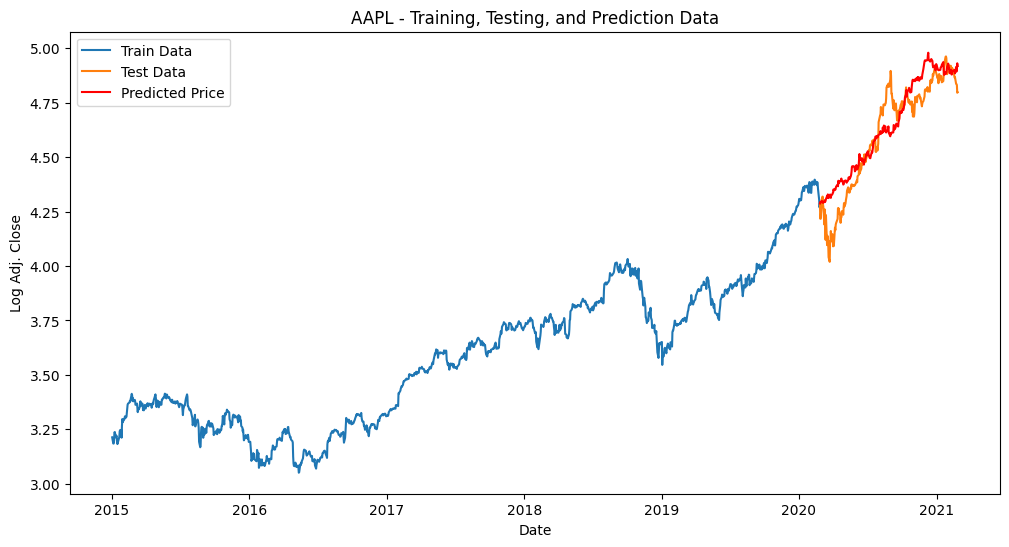

Predictions saved for TSLA in Dataset-A: drive/MyDrive/Modeling and Simulation/MonteCarlo/predictions/Dataset-A/TSLA_predictions.csv


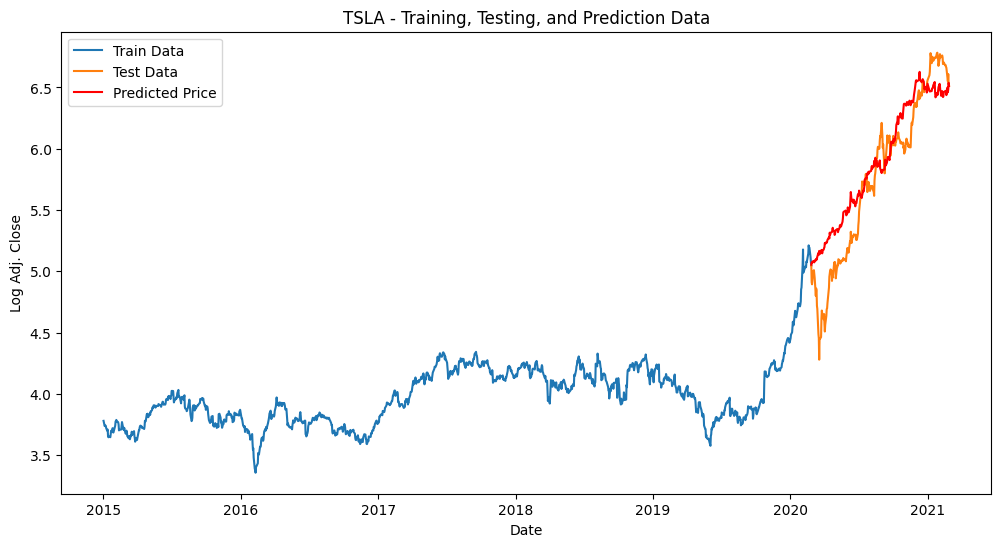

Predictions saved for GOOG in Dataset-A: drive/MyDrive/Modeling and Simulation/MonteCarlo/predictions/Dataset-A/GOOG_predictions.csv


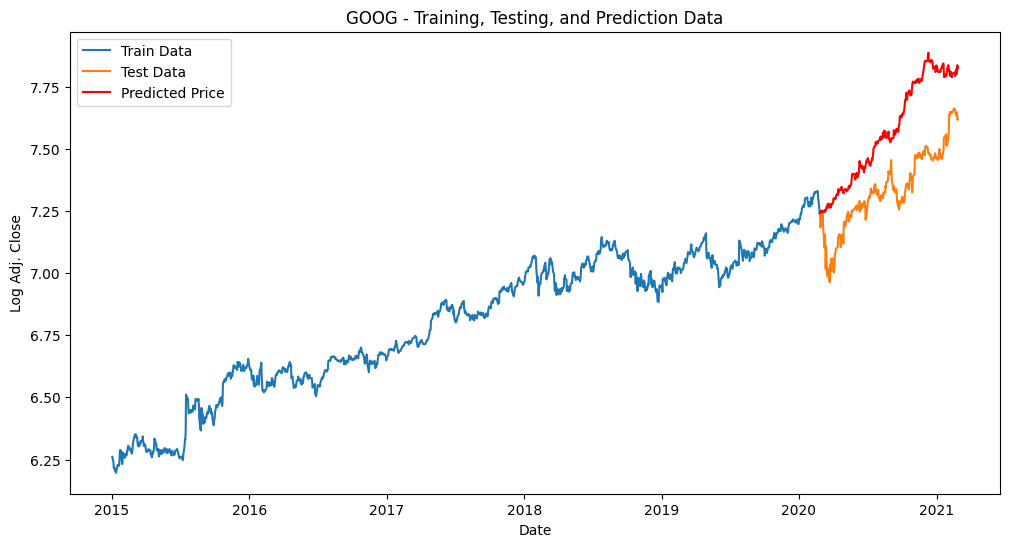

Predictions saved for MSFT in Dataset-A: drive/MyDrive/Modeling and Simulation/MonteCarlo/predictions/Dataset-A/MSFT_predictions.csv


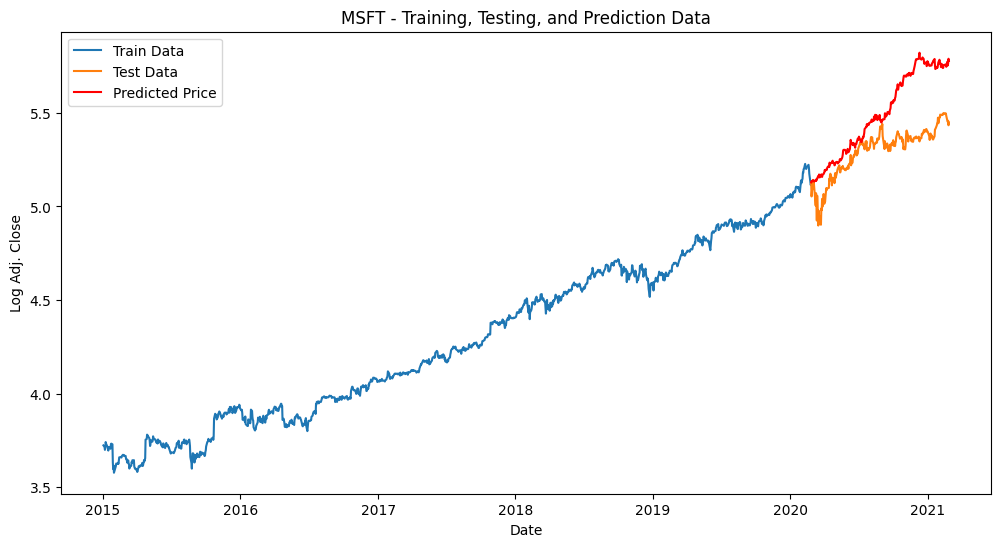

Predictions saved for AMZN in Dataset-A: drive/MyDrive/Modeling and Simulation/MonteCarlo/predictions/Dataset-A/AMZN_predictions.csv


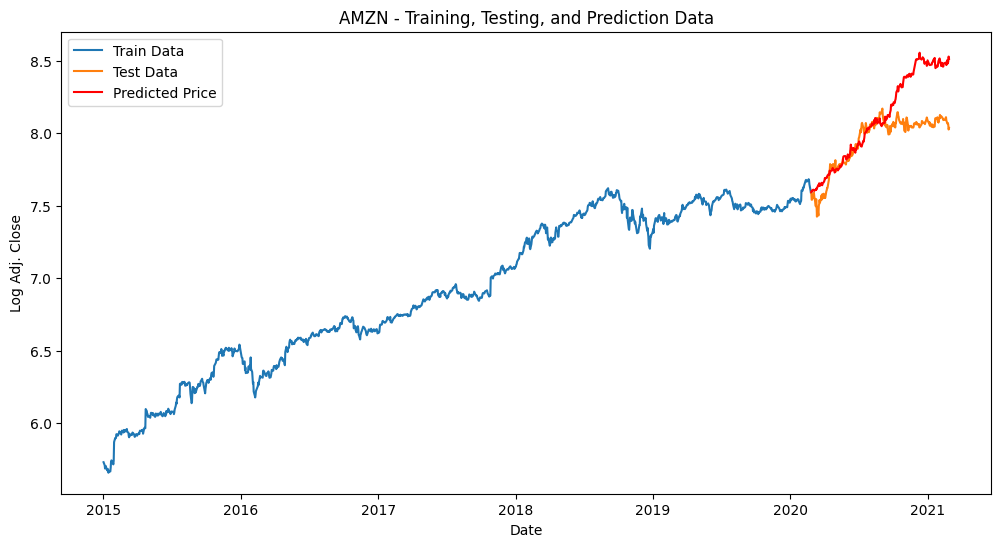

Metrics for Dataset-A saved to drive/MyDrive/Modeling and Simulation/MonteCarlo/metrics/Dataset-A/metrics.csv.
Predictions saved for AAPL in Dataset-B: drive/MyDrive/Modeling and Simulation/MonteCarlo/predictions/Dataset-B/AAPL_predictions.csv


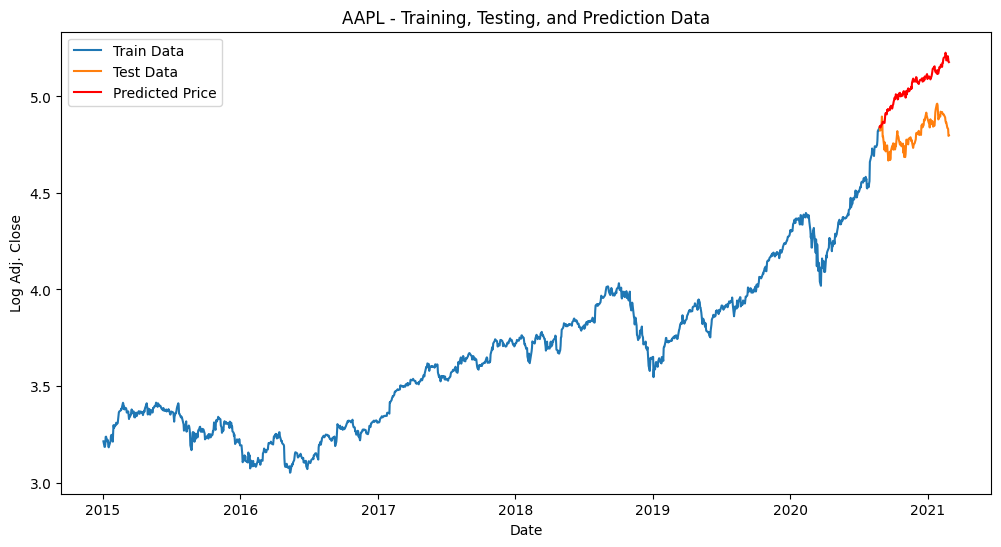

Predictions saved for TSLA in Dataset-B: drive/MyDrive/Modeling and Simulation/MonteCarlo/predictions/Dataset-B/TSLA_predictions.csv


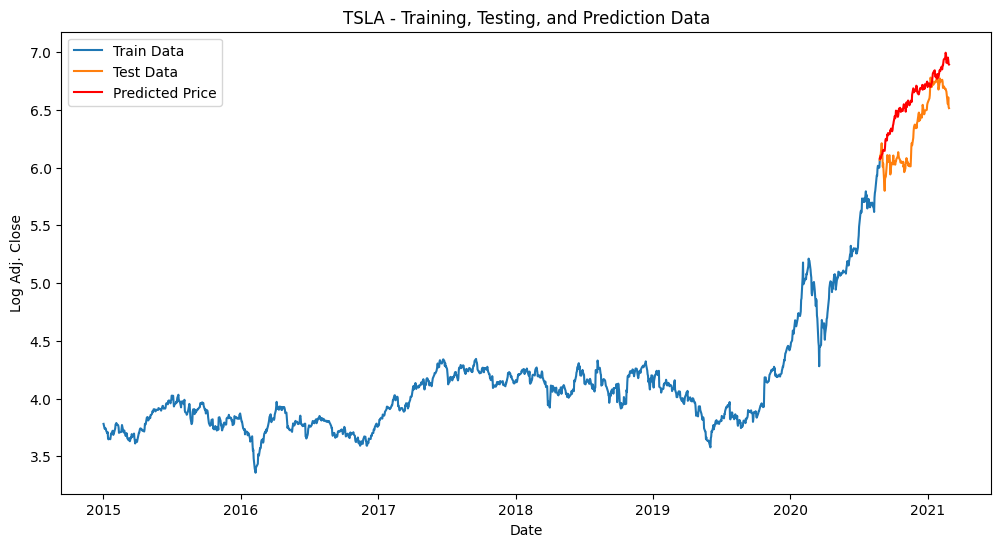

Predictions saved for GOOG in Dataset-B: drive/MyDrive/Modeling and Simulation/MonteCarlo/predictions/Dataset-B/GOOG_predictions.csv


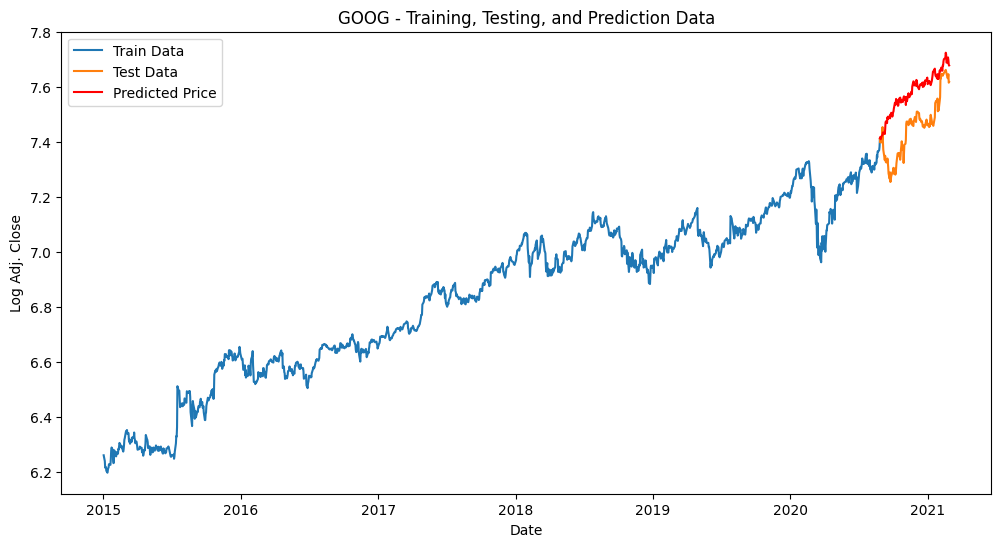

Predictions saved for MSFT in Dataset-B: drive/MyDrive/Modeling and Simulation/MonteCarlo/predictions/Dataset-B/MSFT_predictions.csv


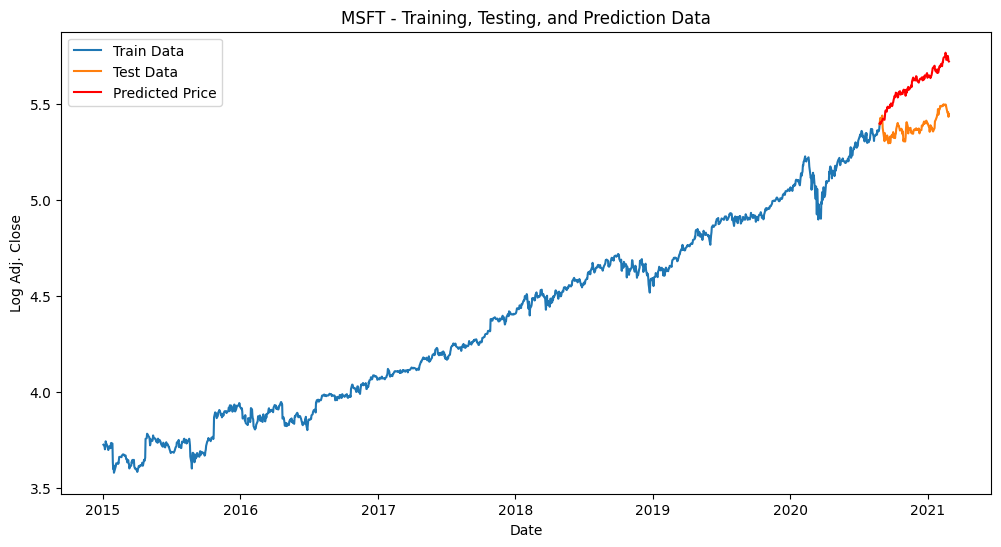

Predictions saved for AMZN in Dataset-B: drive/MyDrive/Modeling and Simulation/MonteCarlo/predictions/Dataset-B/AMZN_predictions.csv


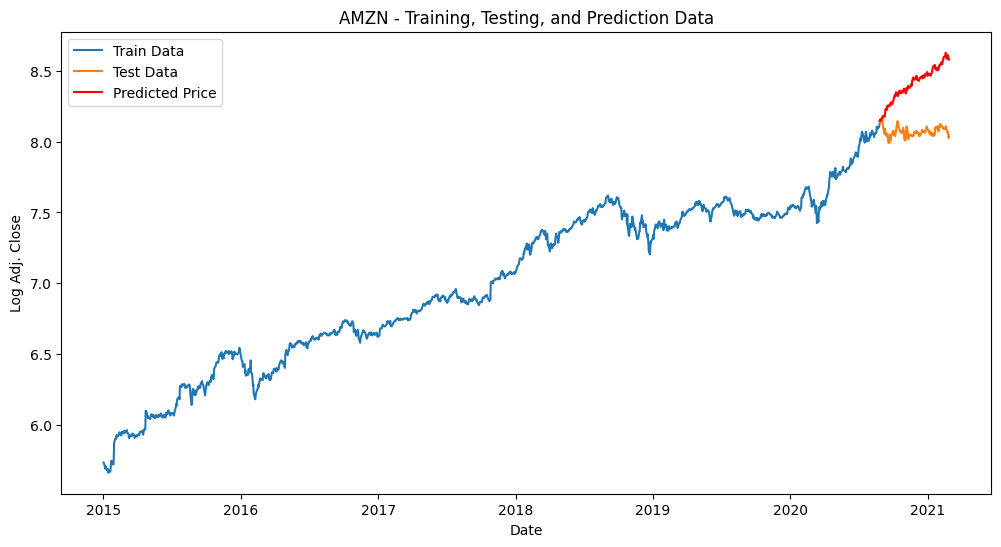

Metrics for Dataset-B saved to drive/MyDrive/Modeling and Simulation/MonteCarlo/metrics/Dataset-B/metrics.csv.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import os

# Paths for database and output directories
database_location = "drive/MyDrive/Modeling and Simulation/Database/"
output_location_predictions = "drive/MyDrive/Modeling and Simulation/MonteCarlo/predictions/"
output_location_metrics = "drive/MyDrive/Modeling and Simulation/MonteCarlo/metrics/"

# Ensure base directories exist
os.makedirs(output_location_predictions, exist_ok=True)
os.makedirs(output_location_metrics, exist_ok=True)

# Dictionary of datasets with periods
datasets = {
    "Dataset-A": {
        "start_date": "2015-01-02",
        "end_date": "2020-02-26",
        "pred_end_date": "2021-02-26"
    },
    "Dataset-B": {
        "start_date": "2015-01-02",
        "end_date": "2020-08-26",
        "pred_end_date": "2021-02-26"
    }
}
# Dictionary of stock files to process
stock_files = {
    "AAPL": "Pre_Processed_AAPL.csv",
    "TSLA": "Pre_Processed_TSLA.csv",
    "GOOG": "Pre_Processed_GOOG.csv",
    "MSFT": "Pre_Processed_MSFT.csv",
    "AMZN": "Pre_Processed_AMZN.csv"
}

# Define the function to load and prepare stock data
def load_stock_data(stock_name, file_path, start_date, end_date, pred_end_date):
    stock_data = pd.read_csv(file_path)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    train_set = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)].set_index('Date')['Adj. Close']
    test_set = stock_data[(stock_data['Date'] >= end_date) & (stock_data['Date'] <= pred_end_date)].set_index('Date')['Adj. Close']
    daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]
    return train_set, test_set, daily_returns

# Monte Carlo simulation for stock price prediction
def run_monte_carlo_simulation(train_set, daily_returns, test_set, scen_size=10000, pred_end_date=None):
    So = train_set.iloc[-1]
    dt = 1
    n_of_wkdays = pd.date_range(start=train_set.index[-1], end=pred_end_date, freq='B').size
    T = n_of_wkdays
    N = int(T / dt)
    t = np.arange(1, N + 1)

    mu = np.mean(daily_returns)
    sigma = np.std(daily_returns)

    np.random.seed(42)
    b = {str(scen): np.random.normal(0, 1, N) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

    S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
    S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))

    S_max = [S[:, i].max() for i in range(0, N + 1)]
    S_min = [S[:, i].min() for i in range(0, N + 1)]
    S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)

    min_length = min(len(S_pred[1:]), len(test_set.index))
    S_pred = S_pred[1:min_length + 1]

    final_df = pd.DataFrame(data={'Date': test_set.index[:min_length], 'Actual_Adj_Close': test_set.values[:min_length], 'Predicted_Adj_Close': S_pred})
    final_df.set_index('Date', inplace=True)

    return final_df

# Plotting function for results
def plot_results(stock_name, train_set, test_set, final_df):
    plt.figure(figsize=(12, 6))
    plt.plot(train_set.index, np.log(train_set), label='Train Data')
    plt.plot(test_set.index, np.log(test_set), label='Test Data')
    plt.plot(final_df.index, np.log(final_df['Predicted_Adj_Close']), label='Predicted Price', color='red')
    plt.title(f"{stock_name} - Training, Testing, and Prediction Data")
    plt.xlabel("Date")
    plt.ylabel("Log Adj. Close")
    plt.legend(loc='best')
    plt.show()

# Main function to run Monte Carlo analysis and calculate metrics
def run_monte_carlo_for_dataset(dataset_name, dataset_params):
    dataset_predictions_dir = os.path.join(output_location_predictions, dataset_name)
    dataset_metrics_dir = os.path.join(output_location_metrics, dataset_name)
    os.makedirs(dataset_predictions_dir, exist_ok=True)
    os.makedirs(dataset_metrics_dir, exist_ok=True)

    metrics_list = []
    for stock, file in stock_files.items():
        file_path = os.path.join(database_location, file)
        train_set, test_set, daily_returns = load_stock_data(stock, file_path, dataset_params['start_date'], dataset_params['end_date'], dataset_params['pred_end_date'])
        final_df = run_monte_carlo_simulation(train_set, daily_returns, test_set, scen_size=10000, pred_end_date=dataset_params['pred_end_date'])

        # Save predictions
        predictions_file = os.path.join(dataset_predictions_dir, f"{stock}_predictions.csv")
        final_df.to_csv(predictions_file, index_label="Date")
        print(f"Predictions saved for {stock} in {dataset_name}: {predictions_file}")

        # Plot results
        plot_results(stock, train_set, test_set, final_df)

        # Calculate metrics
        actual_values = final_df['Actual_Adj_Close'].values
        predicted_values = final_df['Predicted_Adj_Close'].values

        mse = mean_squared_error(actual_values, predicted_values)
        mae = mean_absolute_error(actual_values, predicted_values)
        rmse = math.sqrt(mse)
        non_zero_actuals = actual_values != 0
        mape = np.mean(np.abs(predicted_values[non_zero_actuals] - actual_values[non_zero_actuals]) / np.abs(actual_values[non_zero_actuals]))

        metrics = {
            "Stock": stock,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        }
        metrics_list.append(metrics)

    # Save metrics
    metrics_df = pd.DataFrame(metrics_list)
    metrics_file = os.path.join(dataset_metrics_dir, "metrics.csv")
    metrics_df.to_csv(metrics_file, index=False)
    print(f"Metrics for {dataset_name} saved to {metrics_file}.")

# Loop through datasets and process each stock
for dataset_name, dataset_params in datasets.items():
    run_monte_carlo_for_dataset(dataset_name, dataset_params)

In [ ]:
.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import os
import random
import time
# Paths for database and output directories
database_location = "drive/MyDrive/Modeling and Simulation/Database/"
output_location_predictions = "drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/"
output_location_metrics = "drive/MyDrive/Modeling and Simulation/JumpDiffusion/metrics/"

# Ensure base directories exist
os.makedirs(output_location_predictions, exist_ok=True)
os.makedirs(output_location_metrics, exist_ok=True)

# Datasets with specific periods
datasets = {
    "Dataset-A": {
        "start_date": "2015-01-02",
        "end_date": "2020-02-26",
        "pred_end_date": "2021-02-26"
    },
    "Dataset-B": {
        "start_date": "2015-01-02",
        "end_date": "2020-08-26",
        "pred_end_date": "2021-02-26"
    }
}

# Dictionary of stock files to process
stock_files = {
    "AAPL": "Pre_Processed_AAPL.csv",
    "TSLA": "Pre_Processed_TSLA.csv",
    "GOOG": "Pre_Processed_GOOG.csv",
    "MSFT": "Pre_Processed_MSFT.csv",
    "AMZN": "Pre_Processed_AMZN.csv"
}

# Load and prepare stock data
def load_stock_data(stock_name, file_path, start_date, end_date, pred_end_date):
    stock_data = pd.read_csv(file_path)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    train_set = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)].set_index('Date')['Adj. Close']
    test_set = stock_data[(stock_data['Date'] >= end_date) & (stock_data['Date'] <= pred_end_date)].set_index('Date')['Adj. Close']
    daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]
    return train_set, test_set, daily_returns

# Jump-Diffusion Monte Carlo simulation for stock price prediction
def run_jump_diffusion_simulation(train_set, daily_returns, test_set, scen_size=10000, pred_end_date=None, jump_prob=0.01, jump_mean=0.02, jump_std=0.04):
    So = train_set.iloc[-1]
    dt = 1
    n_of_wkdays = pd.date_range(start=train_set.index[-1], end=pred_end_date, freq='B').size
    T = n_of_wkdays
    N = int(T / dt)
    t = np.arange(1, N + 1)

    mu = np.mean(daily_returns)
    sigma = np.std(daily_returns)

    np.random.seed(42)
    b = {str(scen): np.random.normal(0, 1, N) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

    jumps = {str(scen): np.random.binomial(1, jump_prob, N) * np.random.normal(jump_mean, jump_std, N) for scen in range(1, scen_size + 1)}

    S = np.array([So * np.exp(drift + diffusion[str(scen)] + jumps[str(scen)].cumsum()) for scen in range(1, scen_size + 1)])
    S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))

    S_max = [S[:, i].max() for i in range(0, N + 1)]
    S_min = [S[:, i].min() for i in range(0, N + 1)]
    S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)

    min_length = min(len(S_pred[1:]), len(test_set.index))
    S_pred = S_pred[1:min_length + 1]

    final_df = pd.DataFrame(data={'Date': test_set.index[:min_length], 'Actual_Adj_Close': test_set.values[:min_length], 'Predicted_Adj_Close': S_pred})
    final_df.set_index('Date', inplace=True)

    return final_df, S

# Main function to run Jump-Diffusion analysis for each dataset
def run_jump_diffusion_for_dataset(dataset_name, dataset_params):
    dataset_predictions_dir = os.path.join(output_location_predictions, dataset_name)
    dataset_metrics_dir = os.path.join(output_location_metrics, dataset_name)
    os.makedirs(dataset_predictions_dir, exist_ok=True)
    os.makedirs(dataset_metrics_dir, exist_ok=True)

    metrics_list = []
    for stock, file in stock_files.items():
        file_path = os.path.join(database_location, file)
        train_set, test_set, daily_returns = load_stock_data(stock, file_path, dataset_params['start_date'], dataset_params['end_date'], dataset_params['pred_end_date'])
        final_df, S = run_jump_diffusion_simulation(train_set, daily_returns, test_set, scen_size=10000, pred_end_date=dataset_params['pred_end_date'])

        # Save predictions
        predictions_file = os.path.join(dataset_predictions_dir, f"{stock}_predictions.csv")
        final_df.to_csv(predictions_file, index=True)
        print(f"Predictions saved for {stock} in {dataset_name}: {predictions_file}")

        # Calculate metrics
        actual_values = final_df['Actual_Adj_Close'].values
        predicted_values = final_df['Predicted_Adj_Close'].values

        mse = mean_squared_error(actual_values, predicted_values)
        mae = mean_absolute_error(actual_values, predicted_values)
        rmse = math.sqrt(mse)
        non_zero_actuals = actual_values != 0
        mape = np.mean(np.abs(predicted_values[non_zero_actuals] - actual_values[non_zero_actuals]) / np.abs(actual_values[non_zero_actuals]))

        metrics = {
            "Stock": stock,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        }
        metrics_list.append(metrics)

    # Save metrics for the dataset
    metrics_df = pd.DataFrame(metrics_list)
    metrics_file = os.path.join(dataset_metrics_dir, "metrics.csv")
    metrics_df.to_csv(metrics_file, index=False)
    print(f"Metrics for {dataset_name} saved to {metrics_file}.")

# Process each dataset
for dataset_name, dataset_params in datasets.items():
    run_jump_diffusion_for_dataset(dataset_name, dataset_params)

Predictions saved for AAPL in Dataset-A: drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/Dataset-A/AAPL_predictions.csv
Predictions saved for TSLA in Dataset-A: drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/Dataset-A/TSLA_predictions.csv
Predictions saved for GOOG in Dataset-A: drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/Dataset-A/GOOG_predictions.csv
Predictions saved for MSFT in Dataset-A: drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/Dataset-A/MSFT_predictions.csv
Predictions saved for AMZN in Dataset-A: drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/Dataset-A/AMZN_predictions.csv
Metrics for Dataset-A saved to drive/MyDrive/Modeling and Simulation/JumpDiffusion/metrics/Dataset-A/metrics.csv.
Predictions saved for AAPL in Dataset-B: drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/Dataset-B/AAPL_predictions.csv
Predictions saved for TSLA in Dataset-B: drive/MyDrive/Modeling and Si

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import os
import random
import time

# Paths for database and output directories
database_location = "drive/MyDrive/Modeling and Simulation/Database/"
output_location_predictions = "drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/"
output_location_metrics = "drive/MyDrive/Modeling and Simulation/JumpDiffusion/metrics/"

# Ensure base directories exist
os.makedirs(output_location_predictions, exist_ok=True)
os.makedirs(output_location_metrics, exist_ok=True)

# Datasets with specific periods
datasets = {
    "Dataset-A": {
        "start_date": "2015-01-02",
        "end_date": "2020-02-26",
        "pred_end_date": "2021-02-26"
    },
    "Dataset-B": {
        "start_date": "2015-01-02",
        "end_date": "2020-08-26",
        "pred_end_date": "2021-02-26"
    }
}

# Dictionary of stock files to process
stock_files = {
    "AAPL": "Pre_Processed_AAPL.csv",
    "TSLA": "Pre_Processed_TSLA.csv",
    "GOOG": "Pre_Processed_GOOG.csv",
    "MSFT": "Pre_Processed_MSFT.csv",
    "AMZN": "Pre_Processed_AMZN.csv"
}

# Load and prepare stock data
def load_stock_data(stock_name, file_path, start_date, end_date, pred_end_date):
    stock_data = pd.read_csv(file_path)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    train_set = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)].set_index('Date')['Adj. Close']
    test_set = stock_data[(stock_data['Date'] >= end_date) & (stock_data['Date'] <= pred_end_date)].set_index('Date')['Adj. Close']
    daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]
    return train_set, test_set, daily_returns

# Jump-Diffusion Monte Carlo simulation for stock price prediction
def run_jump_diffusion_simulation(train_set, daily_returns, test_set, scen_size=10000, pred_end_date=None, jump_prob=0.01, jump_mean=0.02, jump_std=0.04):
    So = train_set.iloc[-1]
    dt = 1
    n_of_wkdays = pd.date_range(start=train_set.index[-1], end=pred_end_date, freq='B').size
    T = n_of_wkdays
    N = int(T / dt)
    t = np.arange(1, N + 1)

    mu = np.mean(daily_returns)
    sigma = np.std(daily_returns)

    np.random.seed(42)
    b = {str(scen): np.random.normal(0, 1, N) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

    jumps = {str(scen): np.random.binomial(1, jump_prob, N) * np.random.normal(jump_mean, jump_std, N) for scen in range(1, scen_size + 1)}

    S = np.array([So * np.exp(drift + diffusion[str(scen)] + jumps[str(scen)].cumsum()) for scen in range(1, scen_size + 1)])
    S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))

    S_max = [S[:, i].max() for i in range(0, N + 1)]
    S_min = [S[:, i].min() for i in range(0, N + 1)]
    S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)

    min_length = min(len(S_pred[1:]), len(test_set.index))
    S_pred = S_pred[1:min_length + 1]

    final_df = pd.DataFrame(data={'Date': test_set.index[:min_length], 'Actual_Adj_Close': test_set.values[:min_length], 'Predicted_Adj_Close': S_pred})
    final_df.set_index('Date', inplace=True)

    return final_df, S

# Main function to run Jump-Diffusion analysis for each dataset
def run_jump_diffusion_for_dataset(dataset_name, dataset_params):
    dataset_predictions_dir = os.path.join(output_location_predictions, dataset_name)
    dataset_metrics_dir = os.path.join(output_location_metrics, dataset_name)
    os.makedirs(dataset_predictions_dir, exist_ok=True)
    os.makedirs(dataset_metrics_dir, exist_ok=True)

    metrics_list = []
    for stock, file in stock_files.items():
        file_path = os.path.join(database_location, file)
        train_set, test_set, daily_returns = load_stock_data(stock, file_path, dataset_params['start_date'], dataset_params['end_date'], dataset_params['pred_end_date'])
        final_df, S = run_jump_diffusion_simulation(train_set, daily_returns, test_set, scen_size=10000, pred_end_date=dataset_params['pred_end_date'])

        # Save predictions
        predictions_file = os.path.join(dataset_predictions_dir, f"{stock}_predictions.csv")
        final_df.to_csv(predictions_file, index=True)
        print(f"Predictions saved for {stock} in {dataset_name}: {predictions_file}")

        # Calculate metrics
        actual_values = final_df['Actual_Adj_Close'].values
        predicted_values = final_df['Predicted_Adj_Close'].values

        mse = mean_squared_error(actual_values, predicted_values)
        mae = mean_absolute_error(actual_values, predicted_values)
        rmse = math.sqrt(mse)
        non_zero_actuals = actual_values != 0
        mape = np.mean(np.abs(predicted_values[non_zero_actuals] - actual_values[non_zero_actuals]) / np.abs(actual_values[non_zero_actuals]))

        metrics = {
            "Stock": stock,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        }
        metrics_list.append(metrics)

    # Save metrics for the dataset
    metrics_df = pd.DataFrame(metrics_list)
    metrics_file = os.path.join(dataset_metrics_dir, "metrics.csv")
    metrics_df.to_csv(metrics_file, index=False)
    print(f"Metrics for {dataset_name} saved to {metrics_file}.")

# Measure execution time for a single dataset
dataset_to_run = "Dataset-A"  # Change to the desired dataset
dataset_params = datasets[dataset_to_run]

start_time = time.time()

run_jump_diffusion_for_dataset(dataset_to_run, dataset_params)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time for {dataset_to_run}: {execution_time:.2f} seconds.")

Predictions saved for AAPL in Dataset-A: drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/Dataset-A/AAPL_predictions.csv
Predictions saved for TSLA in Dataset-A: drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/Dataset-A/TSLA_predictions.csv
Predictions saved for GOOG in Dataset-A: drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/Dataset-A/GOOG_predictions.csv
Predictions saved for MSFT in Dataset-A: drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/Dataset-A/MSFT_predictions.csv
Predictions saved for AMZN in Dataset-A: drive/MyDrive/Modeling and Simulation/JumpDiffusion/predictions/Dataset-A/AMZN_predictions.csv
Metrics for Dataset-A saved to drive/MyDrive/Modeling and Simulation/JumpDiffusion/metrics/Dataset-A/metrics.csv.
Execution time for Dataset-A: 2.97 seconds.


In [6]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Paths for database and output directories
database_location = "drive/MyDrive/Modeling and Simulation/Database/"
output_location_metrics = "drive/MyDrive/Modeling and Simulation/JumpDiffusion/metrics/"
os.makedirs(output_location_metrics, exist_ok=True)

# Datasets with specific periods
datasets = {
    "Dataset-A": {
        "start_date": "2015-01-02",
        "end_date": "2020-02-26",
        "pred_end_date": "2021-02-26"
    },
    "Dataset-B": {
        "start_date": "2015-01-02",
        "end_date": "2020-08-26",
        "pred_end_date": "2021-02-26"
    }
}

# Stock files to process
stock_files = {
    "AAPL": "Pre_Processed_AAPL.csv"
}

# Simulation sizes to evaluate
simulation_sizes = [100, 10000, 50000]

# Load and prepare stock data
def load_stock_data(file_path, start_date, end_date, pred_end_date):
    stock_data = pd.read_csv(file_path)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    train_set = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)].set_index('Date')['Adj. Close']
    test_set = stock_data[(stock_data['Date'] > end_date) & (stock_data['Date'] <= pred_end_date)].set_index('Date')['Adj. Close']
    daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]
    return train_set, test_set, daily_returns

# Jump-Diffusion Monte Carlo simulation
def run_jump_diffusion_simulation(train_set, daily_returns, test_set, scen_size, pred_end_date, jump_prob=0.01, jump_mean=0.02, jump_std=0.04):
    So = train_set.iloc[-1]
    dt = 1
    n_of_wkdays = pd.date_range(start=train_set.index[-1], end=pred_end_date, freq='B').size
    T = n_of_wkdays
    N = int(T / dt)
    t = np.arange(1, N + 1)

    mu = np.mean(daily_returns)
    sigma = np.std(daily_returns)

    np.random.seed(42)
    b = {str(scen): np.random.normal(0, 1, N) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
    jumps = {str(scen): np.random.binomial(1, jump_prob, N) * np.random.normal(jump_mean, jump_std, N) for scen in range(1, scen_size + 1)}

    S = np.array([So * np.exp(drift + diffusion[str(scen)] + jumps[str(scen)].cumsum()) for scen in range(1, scen_size + 1)])
    S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))

    S_max = [S[:, i].max() for i in range(0, N + 1)]
    S_min = [S[:, i].min() for i in range(0, N + 1)]
    S_pred = 0.5 * np.array(S_max) + 0.5 * np.array(S_min)

    min_length = min(len(S_pred[1:]), len(test_set.index))
    S_pred = S_pred[1:min_length + 1]

    final_df = pd.DataFrame(data={'Date': test_set.index[:min_length], 'Actual_Adj_Close': test_set.values[:min_length], 'Predicted_Adj_Close': S_pred})
    final_df.set_index('Date', inplace=True)

    return final_df

# Main function for simulation sizes
def evaluate_simulation_sizes(dataset_name, dataset_params):
    results_list = []
    metrics_dir = os.path.join(output_location_metrics, dataset_name)
    os.makedirs(metrics_dir, exist_ok=True)

    for sim_size in simulation_sizes:
        for stock, file in stock_files.items():
            file_path = os.path.join(database_location, file)
            train_set, test_set, daily_returns = load_stock_data(file_path, dataset_params['start_date'], dataset_params['end_date'], dataset_params['pred_end_date'])
            final_df = run_jump_diffusion_simulation(train_set, daily_returns, test_set, scen_size=sim_size, pred_end_date=dataset_params['pred_end_date'])

            # Calculate metrics
            actual_values = final_df['Actual_Adj_Close'].values
            predicted_values = final_df['Predicted_Adj_Close'].values

            mse = mean_squared_error(actual_values, predicted_values)
            mae = mean_absolute_error(actual_values, predicted_values)
            rmse = math.sqrt(mse)
            non_zero_actuals = actual_values != 0
            mape = np.mean(np.abs(predicted_values[non_zero_actuals] - actual_values[non_zero_actuals]) / np.abs(actual_values[non_zero_actuals]))

            results_list.append({
                "Simulation Size": sim_size,
                "MSE": mse,
                "MAE": mae,
                "RMSE": rmse,
                "MAPE": mape
            })

    # Save results to CSV
    results_df = pd.DataFrame(results_list)
    results_file = os.path.join(metrics_dir, "simulation_size_metrics.csv")
    results_df.to_csv(results_file, index=False)
    print(f"Simulation size metrics saved to {results_file}.")

# Run for Dataset-A
evaluate_simulation_sizes("Dataset-A", datasets["Dataset-A"])

Simulation size metrics saved to drive/MyDrive/Modeling and Simulation/JumpDiffusion/metrics/Dataset-A/simulation_size_metrics.csv.
